# <center>Example pipeline of decoding_model_bids_fmri </center>
This notebook contains an example pipeline of decoding_model_bids. The pipeline leads you from .wav stimulus files and aligned fmri bold data to reconstruction accuracy of fitted decoding models.

The project assumes you have aligned fmri data and stimulus (audio) files from Forrest Gump dataset downloaded.
The description of the dataset can be found [here](https://www.nature.com/articles/sdata20143#Sec41).
Once you have donwloaded the dataset, just change *path_to_project* for your local path.

## Project folder structure
The project assumes the following folder structure:
    
    /decoding_model_bids/      
                          /code/
                          /raw data/stimuli/
                                   /aligned/
                                   /processed_stimuli/
                          /bids_folder/
                          /processed_data/
                          /decoding_data/


- **raw_data** contains data which will later on be organized into BIDS compliant format. <br>
    - *stimuli* contains original audio files in wav format. We will extract features from them later on.
    - *aligned* folder contains aligned bold fmri data for each subject which was aligned with audio stimuli.
    - *processed_stimuli* contains the stimulus representation produced by feature extractor.
- **bids_folder** contains bold frmi data and extracted stimulus representation for each subject in BOLD compliant format.
- **processed_data** contains bold data and stimulus representation which is preprocessed and ready for training decoding model on.
- **decoding_data** contains the results of running different decoding models on processed_data.

The starting point of the tutorial is having wav files and BOLD fMRI data aligned with them stored in "raw_data" folder. Once you have that ready, we can move on to the pipeline.

The most general workflow consists of 3 steps:
1. extracting features from auditory stimuli (<strong>audio2bidsstim</strong>);
2. distributing (storing) extracted stimulus representation and BOLD files into bids-compliant folder (<strong>data_distribution</strong>); 
3. running decoding models(<strong>decoding</strong>).
The code folder is separated into 3 sections according to the abovementioned logic.

## 1. Auditory feature extraction from wav files (/code/audio2bidsstim)
The code to extract feature representation from audio files is stored in /code/audio2bidsstim/ folder.
As you can see, there are 3 files in this directory:

In [18]:
%%bash
path_to_project="/data/akitaitsev"
ls $path_to_project"/decoding_model_bids/code/audio2bidsstim/"

mps_input_config_exp1.json
__pycache__
run_mps_feature_extraction.sh
wav_files_to_bids_tsv.py


The feature extractor function is contained in *wav_files_to_bids_tsv.py* python script.

A good way to achieve better decoding accuracy is to reconstruct not a sound time-series directly, but to "pack" it first into some higher-level representation. This representation will no longer contain sound time-series, but feature time-seires (derived from audiogram). The *wav_files_to_bids_tsv.py* offers 2 different functions for feature extraction.<br> 

1. **Mel-spectrogram** is an efficient way to represent auditory stimuli in the form of frequencies time-series. Its's a wee different from "ususal" spectrogram obtained by STFT (short time Fourier trasnform) as it uses unevenly spaced frequenciy intervals. For more elaborate explanation of the mel-spectrogram check out this [website](https://medium.com/analytics-vidhya/understanding-the-mel-spectrogram-fca2afa2ce53). 
2. **Modulation Power Spectrum (MPS)** is a high level sound representation allowing to estimate the "speed" of change of singal frequency in time (modulations/s) and in frequency (modulations/Hz). For more details see this [article](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1000302).

In this project we will only use MPS as a stimulus representation.

Function which extracts MPS from audio time-series is rather complex and the elaborate explanation of it's functionality is beyond the scope of this notebook. Below I will discuss the meanining of some of the input  parameters.

In [26]:
%%bash 
path_to_project="/data/akitaitsev"
cd $path_to_project"/decoding_model_bids/code/audio2bidsstim/"

In [27]:
from audio2bidsstim.wav_files_to_bids_tsv import mps_stft
help(mps_stft) 

Help on function mps_stft in module audio2bidsstim.wav_files_to_bids_tsv:

mps_stft(filepath, sr, n_fft_stft, hop_length_stft, n_fft_mps, hop_length_mps, use_power=True, log=True, dB=False, plot_spectr=False, plot_mps=False, return_figures=False, cutoff_temp_mod=50, cutoff_spectr_mod=50, dec=2, **kwargs)
    Function to create modulation power spectra from wav file via 2d FFT of STFT spectrogram.
    Function also saves its configuration to the output directory as json file
    
    Inputs:
        
    filepath -          path to the wav file
    sr -                sampling rate of wav file
    hop_length_stft -   step size for librosa stft
    n_fft_stft -        window size of stft
    n_fft_mps -         window size for 2d Fourier transform of spectrogram (along the time axis)
    hop_length_mps -    step size of 2d Fourier transform of spectrogram along the time axis
    use_power -         use power spectrum instead of amplitude (ampl^2). (default = True)
    log -              

As you can see from the function help, there are quite a few parameters user can specify. The general algorithm behid this function is as follows:
1. Transform the audio time-series into spectrogram (frequency time-series). This step is controlled by the length of the windows in samples (*n_fft_stft*) and the step between the windows (*hop_length_stft*).
2. Separate spectrogram time-series into windows. Apply 2 dimensional FFT to each of the windows to obtain Modulation Power Spectrum (MPS) of each window. This step is controlled by window size along the temporal (x) axis (*n_fft_mps*) and the transition step of this window along the spectrogram time series (*hop_length_mps*).
3. Reshape 2d MPS for each window into 1d array and concatenate obtained 1d arrays into 2d array of features time-series (time, features). <br>

It also worth mentioning that during 2d FFT step the function stores complex components of the output of 2dFFT as they will be used for reconstruction of the spectrogram from the predicted MPS in decoding part of the notebook. 

Function returns 4 main outputs:
1. *mod_pow_spectrs* - flattened MPS representations for every step of sliding window along spectrogram time-dimension as 2d numpy array of shape (times, n_features), where n_features is the number of elements in a single MPS array (n_features = mod/s*mod/Hz).
2. *mps_phases* - complex components of the output of 2dFFT for each of the windows on which it was applied.
3. *Params* - dictionary containing all the parameters which were used for MPS calculation plus the shape of single original MPS representations (actually, tuple of (mod/s, mod/Hz)).
4. *Metadata* - python dictionary containing the information about feature representation, required by BIDS standard (feature names and repetition time between 2 feature representations).

If return_figures is True, there are also 2 figure handles returned.

Let us call mps_stft with exmample auditory file and feed it the follwoing parameters:


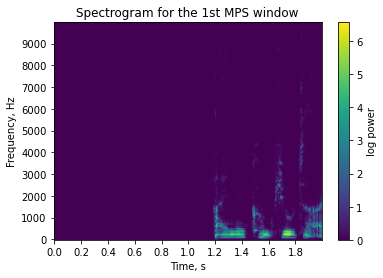

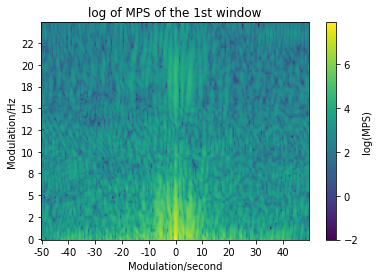

In [3]:
%matplotlib inline
config = {"filepath": "/data/akitaitsev/decoding_model_bids/raw_data/stimuli/0.wav",\
          "sr":20000, "n_fft_stft": 400, "hop_length_stft": 200,\
          "n_fft_mps": 200, "hop_length_mps": 200, "plot_spectr": True, \
          "use_power":True, "log":True, "dB":False, "plot_mps":True, \
          "return_figures": True}
MPS, phases, params, metadata, fig_spectr, fig_mps = mps_stft(**config)

So, we have calculated the spectrogram of the audito time-series, separated it into windows and calculated 2d FFT of each of these windows to obtain the series of MPSs. 

Due to large number of parameters required, we do not call mps_stft function directly, but call *wav_fiels_to_bids_tsv.py*  as the main file and feed to it input dir, output dir and the path to .json file with feature extractor configuration. The start time parameter of *wav_fiels_to_bids_tsv.py*  was not used in this project. 

In [5]:
%%bash
python wav_files_to_bids_tsv.py -h

usage: wav_files_to_bids_tsv.py [-h] [-e EXTRACTOR] [-c CONFIG] [-o OUTPUT]
                                [-t START_TIME [START_TIME ...]]
                                file [file ...]

Wav2bids stim converter.

positional arguments:
  file                  Name of file or space separated list of files or glob
                        expression for wav files to be converted.

optional arguments:
  -h, --help            show this help message and exit
  -e EXTRACTOR, --extractor EXTRACTOR
                        Type of feature extractor to use. mps or mel.
  -c CONFIG, --config CONFIG
                        Path to json file that contains the parameters to
                        librosa's melspectrogram function.
  -o OUTPUT, --output OUTPUT
                        Path to folder where to save tsv and json files, if
                        missing uses current folder.
  -t START_TIME [START_TIME ...], --start-time START_TIME [START_TIME ...]
                        Start time in 

So, to run feature extraction for a single file we shall just call the file wav_files_to_bids_tsv_mps.py and specify the path to stimulus file, extractor to use (MPS or mel-spectrogram), output folder and (for mel-spectrogram) start times. 

- **run_mps_feature_extraction.sh** is a bash script calling the abovementioned process of feature extraction with your own config file and folder. It contains the paths to input files, output folder and mps_config file. It executes wav_fiels_to_bids_tsv.py for every wav file and saves feature_representation,parameters and metadata to the output folder.
So, you have 2 options: either to edit the output folder of the bash script or to call *wav_fiels_to_bids_tsv.py* from the console.
We want to save the output of the feature extractor into 

<br> */your_project_dir/raw_data/processed_stimuli/*

## 2. Distributing (storing) extracted stimulus representation and BOLD files into bids-compliant folder (data_distribution);
When we have extracted the features from the stimulus the next step is to bring together extracted features and bold files into out BIDS-compliant directory.
Functions to do it are stored in the */your_project_dir/code/data_distribution/* directory.
1. **copy_bold_to_bids_folder.py** distributes aligned fRMI BOLD data from arbitrary folder to your bids-compliant folder.
2. **distribute_stimulus_by_BIDS_folders.py** copies stimulus representation files and metadata.json files to your BIDS-compliant folder.

In [13]:
%%bash 
path_to_project="/data/akitaitsev"
cd $path_to_project"/decoding_model_bids/code/data_distribution/"
python copy_bold_to_bids_folder.py -h       
python distribute_stimulus_by_BIDS_folders.py -h 

usage: copy_bold_to_bids_folder.py [-h] [-from FROM_DIR] [-to TO_DIR]

copy aomovoie bold files from aligned folder to your bids folder

optional arguments:
  -h, --help            show this help message and exit
  -from FROM_DIR, --from_dir FROM_DIR
  -to TO_DIR, --to_dir TO_DIR
usage: distribute_stimulus_by_BIDS_folders.py [-h] [-s STIMULI_DIR]
                                              [-b BIDS_DIR]

Distributer of precessed stimuli files by BIDS standard folders.

optional arguments:
  -h, --help            show this help message and exit
  -s STIMULI_DIR, --stimuli_dir STIMULI_DIR
                        directory where all the stimulus are saved by
                        run_mps_feature_extraction.sh script
  -b BIDS_DIR, --bids_dir BIDS_DIR
                        path to the bids directory


In case of our project BOLD files and stimulus representation files were distributed into the *decoding_model_bids/bids_folder/* directory. 

## 3. Decoding - reconstruction of stimulus feature representation from preprocessed fmri data (decoding).

This explains how to run decoding models on data stored in your BIDS-compliant directory.

### - preprocessing.py  <br>
Before running decoding model stimulus represetnation and frmi data shall be preprocessed. During preprocessing the stimulus represetnation are aligned in time (length), fmri is standardized, anatomical (EPI) mask is applied and potentially lagging and different offset times of bold relative to stimulus can be introduced (though it's not the case in our project). The script *preprocessing.py* contains functions used for preprocessing. 
Script *preprocessing.py* contains the functions used for preprocessing.
Feel free to check run_preprocessing documentation.
The preprocessing can be ran for all by calling *run_preprocessing.py* script from bash with specified input (BIDS compliant) and output directories.

In [15]:
%%bash
path_to_project="/data/akitaitsev/"
cd $path_to_project"decoding_model_bids/code/decoding/"
python run_preprocessing.py -h

usage: run_preprocessing.py [-h] [-inp INPUT_DIR] [-out OUTPUT_DIR]

Run preprocessing and lagging on all files in the input directory

optional arguments:
  -h, --help            show this help message and exit
  -inp INPUT_DIR, --input_dir INPUT_DIR
                        path to BIDS directory containing aligned frmi and
                        stimulus representation
  -out OUTPUT_DIR, --output_dir OUTPUT_DIR
                        output directory for preprocessed frmi and stimulus
                        representation.


In case of our project we use */path_to_project/decoding_model_bids/bids_foldr/* as input and */path_to_project/decoding_model_bids/processed_data/* as output.

### - decoding.py
Up to now we were only working with data: creating folder structure, extracting features from stimuli and preprocessing fmri and stimulus representation. decoding.py contains functions building up into decoding model.

Again, it is beyond the scope of this notebook to go into the details of the decdoing.py script, so we will only discuss the general usage issues.
Below there are custom classes and function from decoding.py listed.

In [5]:
import os
path_to_project='/data/akitaitsev/'
os.chdir(os.path.join(path_to_project,'decoding_model_bids/code/decoding'))
import decoding as dec
help(dec)

Help on module decoding:

NAME
    decoding - Decoding model with script_based approach

CLASSES
    sklearn.base.BaseEstimator(builtins.object)
        myRidge
        temporal_decoder
    
    class myRidge(sklearn.base.BaseEstimator)
     |  myRidge(alphas=(0, 5, 5), voxel_selection=True, var_explained=None, n_splits=8, n_splits_gridsearch=5, normalize=True)
     |  
     |  Base class for all estimators in scikit-learn
     |  
     |  Notes
     |  -----
     |  All estimators should specify all the parameters that can be set
     |  at the class level in their ``__init__`` as explicit keyword
     |  arguments (no ``*args`` or ``**kwargs``).
     |  
     |  Method resolution order:
     |      myRidge
     |      sklearn.base.BaseEstimator
     |      builtins.object
     |  
     |  Methods defined here:
     |  
     |  __init__(self, alphas=(0, 5, 5), voxel_selection=True, var_explained=None, n_splits=8, n_splits_gridsearch=5, normalize=True)
     |      kwargs - additional a

In decoding itself is implemented by 2 functions: *decode* and *run_decoding*.<br>
- **decode** accepts fmri, stimulus arrays and decoder object implementing .fit and .predict methods.
Then .fit method of the object is called on "in-sample" and .predict method of the object on out-of-sample data in K fold cross-validation. The function outputs predicted stimulus representation obtained by concatenating out-of-sample predictions.<br>
Note, that the only requirements for the object is to implement .fit and .predict in accordance with sklearn [conventions](https://scikit-learn.org/stable/tutorial/statistical_inference/supervised_learning.html).
- **run_decoding** calls *decode* on every user defined subject and run and stores the output of the model in user defined folder.

In [18]:
help(dec.decode)

Help on function decode in module decoding:

decode(fmri, stim, decoder, n_splits=8)
    Runs decoding one stimulus and fmri runi
    Inputs:
        fmri - 2d numpy array of preprocessed fmri
        stim - 2d numpy array of  preprocessed stim
        decoder - decoder object with .fit and .predict methods
        n_splits - int, number of cross-validation splits;
        Default = 8.
    Outputs:
        predictions - 2d numpy array of predicted stimulus representation



In [19]:
help(dec.run_decoding)

Help on function wrapper in module decoding:

wrapper(*args, **kwargs)

None


- *input_dir* argument for run_decdoing function shall be the output directory of run_preprocessing script.<br>
- *stim_param_dir* shall be the output directory of your feature extractor (where it stored the parameters usied in feature extraction). <br>
- *decoder* shall be object implementing .fit and .predict methods; it is passed to *decode* function.
- *model_config* shall be python dictionary containing list of subjects and runs to run the model on. 
- *output_dir* is the directory where the predicted stimuli and assessment quantities of stimulus reconstruction quality are saved. 

In this framework it is quite easy to test different regression models for reconstructing stimulus representation from preprocessed fMRI data. To begin with, let us use ridge regression for this. 
In the decoding.py script there is a custom class *myRidge* which comes is handy in more complex models afterwards.
From the user perspective it is similar to standard sklearn [RidgeCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html) linear regression.
Let us launch decoding model using Ridge regression to reconstruct stimulus representation from BOLD data of run 1 of the subject 1.
The code to do it is as follows.

saving model data for subject  01...
Elapsed time 6.0251792947451275 minutes.


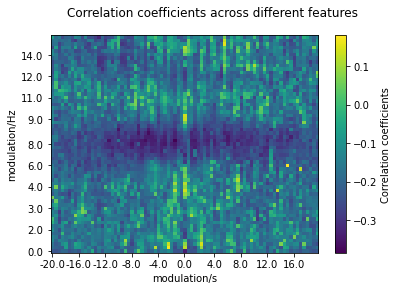

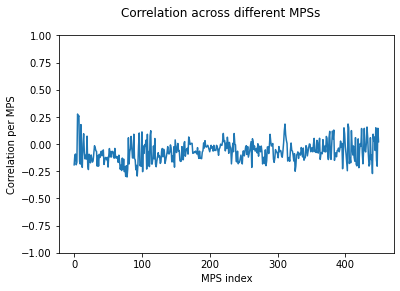

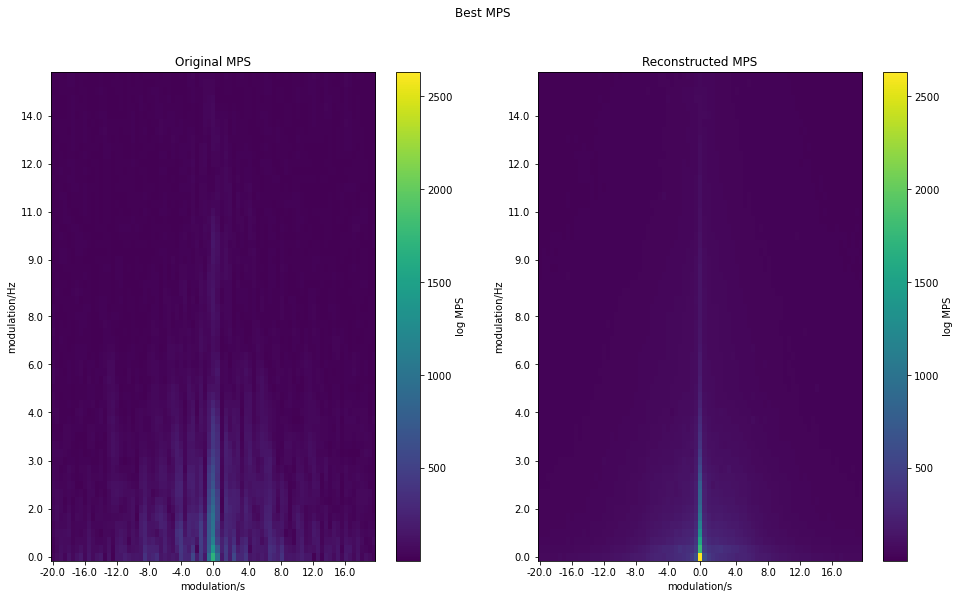

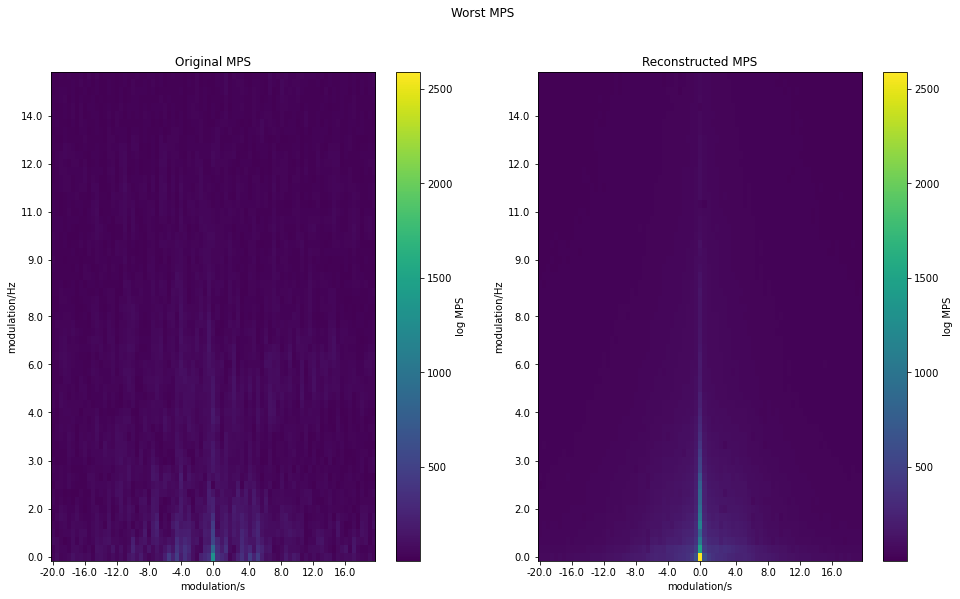

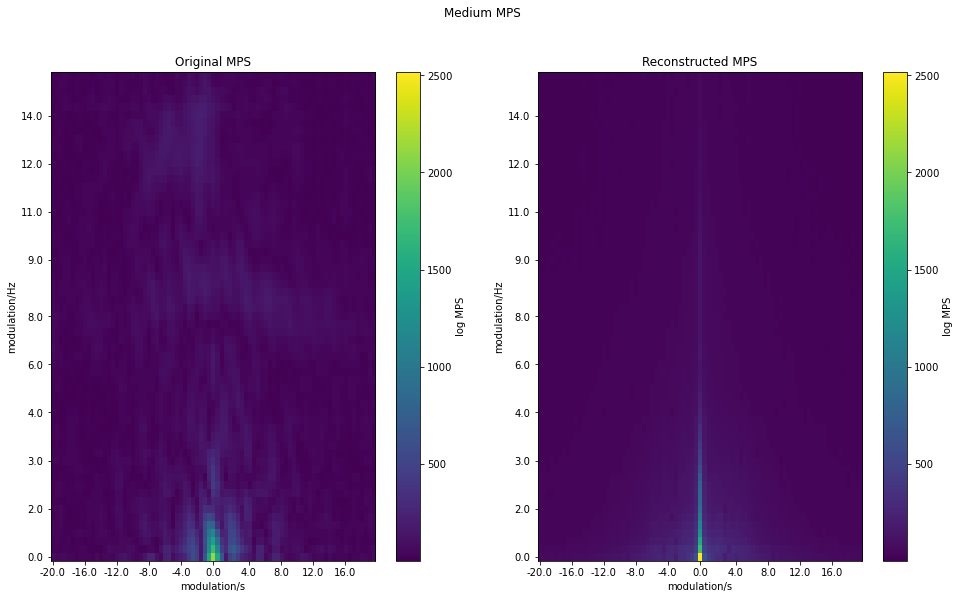

In [2]:
import os
path_to_project='/data/akitaitsev/'
os.chdir(os.path.join(path_to_project,'decoding_model_bids/code/decoding'))
import decoding as dec

ridge_params = {'alphas':[0,5,5], 'normalize':True}
ridge_estimator=dec.myRidge(**ridge_params)

# run model only on run1 of subject 1 
model_config = {'subjects':['01'], 'runs':[[1]]}
input_dir=os.path.join(path_to_project, 'decoding_model_bids/processed_data/')
stim_param_dir = os.path.join(path_to_project, 'decoding_model_bids/raw_data/processed_stimuli/')
output_dir=os.path.join(path_to_project,'decoding_model_bids/decoding_data/test_ridge/')

dec.run_decoding(input_dir, output_dir, stim_param_dir, model_config, ridge_estimator)

The script saved the data into the output folder and produced some pictures (which are also saved).

The first picture is the average correlation of each feature between predicted and original MPS over all different timepoints (MPSs). As we can see, the model is quite noise and the shape of reconstructed MPS only slightly resembles the shape of the original one.

The next picture illustrated correlations of predicted MPS with the original one for each timepoint (MPS).

Following are comparisons of best, worst and medium MPS profiles, bets worst and medium being defined by correlation values for this timepoint (MPS).

Let us examine the output folder.

In [5]:
%%bash 
path_to_project='/data/akitaitsev/'
ls $path_to_project"/decoding_model_bids/decoding_data/test_ridge/sub-01/"

Best_MPS_sub-01.png
correlations_sub-01.pkl
correlations_sub-01.png
figs_sub-01.pkl
Medium_MPS_sub-01.png
mps_inds_sub-01.pkl
r2_sub-01.pkl
R2_sub-01.png
reconstructed_mps_sub-01.pkl
Worst_MPS_sub-01.png


There are 
- *reconstructed_mps_sub-01.pkl*) - predicted stimulus representation of the same shape as the original one;
- *correlations_sub-01.pkl* - correlations between original and reconstructed stimulus representation -one value per MPS window;
- *r2_sub-01.pkl* - the average correlation of each feature of predicted MPS with the original MPS over all different timepoints (MPSs).

All the images presented above are also saved.

We can construct any arbitrary models with multiple preprocessing steps by using sklearn [*Pipeline* function](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html).
When .fit method of Pipeline object is called, it calls .fit_transform (or .fit in case .the object does not implement .fit_transform method) on every successive estimator wrapped in Pipeline.
When .predict method of the Pipeline is called it successively calls .fit_transform method of every estimator but the last one, on which .predict method is called.
Therefore, we can build composite object implementing .fit and .predict methods and feed it to *run_decoding* funtion. 

For instance, we might want to preprocess the BOLD with PCA before feeding it to Ridge regression.
In this case the code is as follows.

Creating folder sub-01 in the directory /data/akitaitsev/decoding_model_bids/decoding_data/test_Pipeline/
saving model data for subject  01...
Elapsed time 0.32097248633702596 minutes.


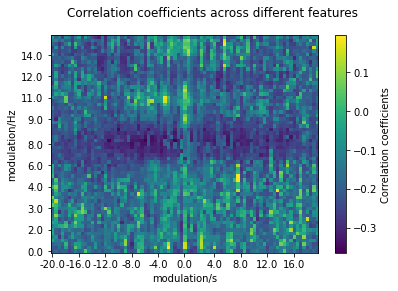

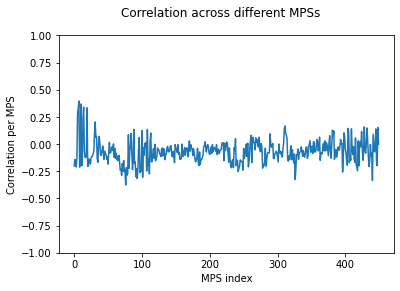

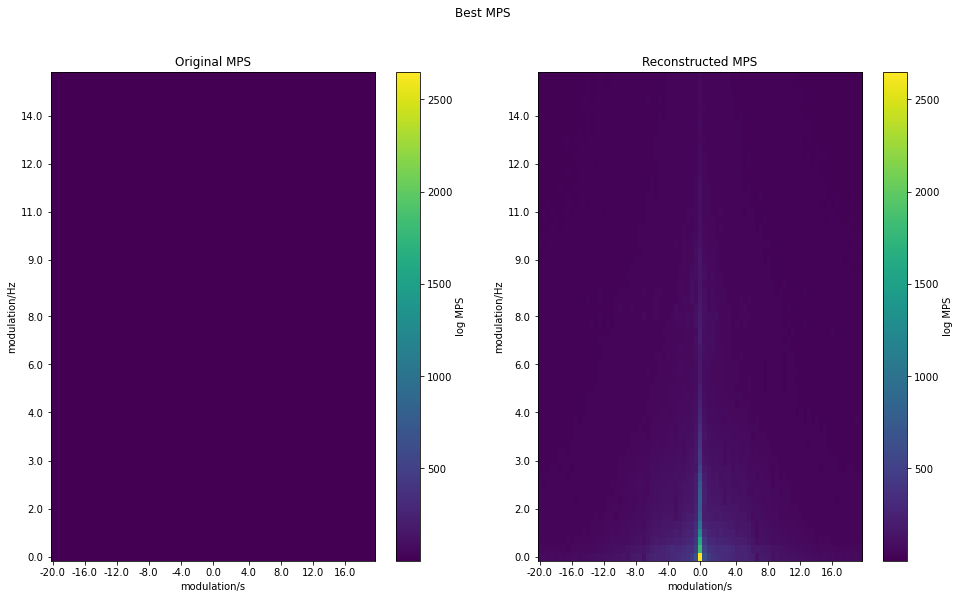

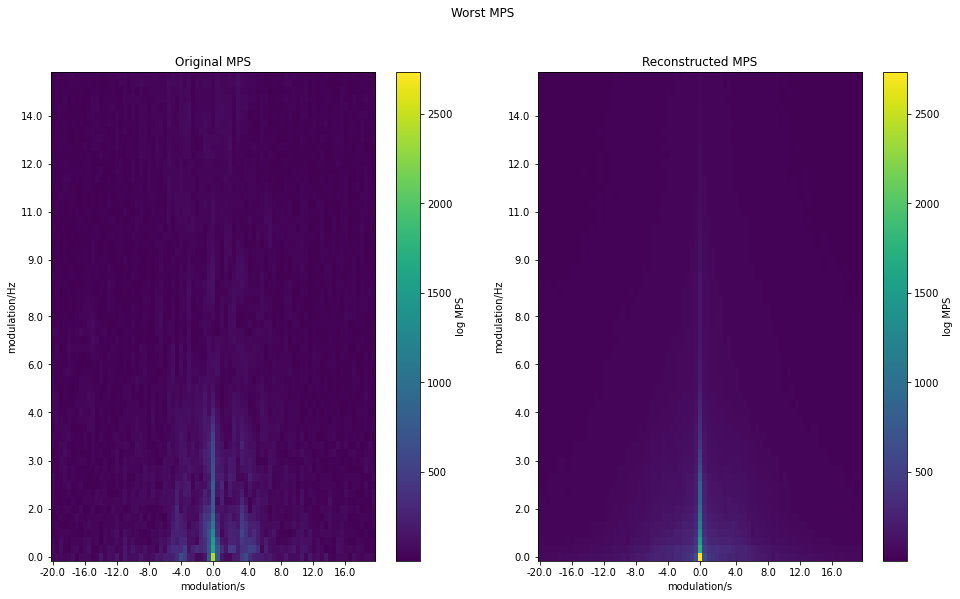

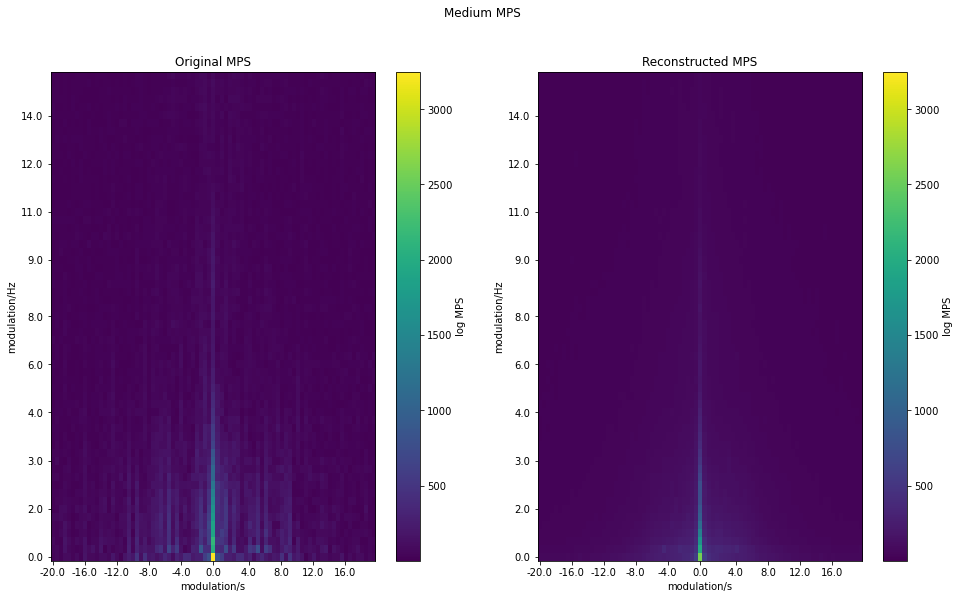

In [7]:
import os
import decoding as dec
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
path_to_project='/data/akitaitsev/'
os.chdir(os.path.join(path_to_project,'decoding_model_bids/code/decoding'))

# defining objetcs
preprocessor = PCA(n_components=30)
ridge_params = {'alphas':[0,5,5], 'normalize':True}
ridge_estimator=dec.myRidge(**ridge_params)

# composing objects into Pipeline
estimator = Pipeline([('preprocessor', preprocessor), ('ridge', ridge_estimator)])

# run model only on run1 of subject 1 
model_config = {'subjects':['01'], 'runs':[[1]]}
input_dir=os.path.join(path_to_project, 'decoding_model_bids/processed_data/')
stim_param_dir = os.path.join(path_to_project, 'decoding_model_bids/raw_data/processed_stimuli/')
output_dir=os.path.join(path_to_project,'decoding_model_bids/decoding_data/test_Pipeline/')

dec.run_decoding(input_dir, output_dir, stim_param_dir, model_config, estimator)

Now we come to the gist of this project: testing different decoding models.
Generally, we used 2 different groups of models:
- **Spatial models (SM)** exploiting solely spatial inforation contained in the bold data (firring separate regression to each BOLD timepoint to reconstruct corresponing MPS).
- **Spatial-temporal models** exploiting temporal information as well as spatial. 

Accomodation of temporal information was acheived by lagging BOLD data and regressing stimulus representation onto stacked BOLD from different lagging iterations. In order to understand what lagging means let us lag a simple 5,4 array of integers.

In [15]:
import numpy as np
ar = np.linspace(1,20,20, endpoint=True).reshape(5,4)
print(ar)
print()

lag_par = 3 # number of iterations of lagging fucntion
lagged_ar = dec.lag(ar, lag_par)
print(lagged_ar)

[[ 1.  2.  3.  4.]
 [ 5.  6.  7.  8.]
 [ 9. 10. 11. 12.]
 [13. 14. 15. 16.]
 [17. 18. 19. 20.]]

[[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16.]
 [ 5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19. 20.]
 [ 9. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19. 20.  0.  0.  0.  0.]
 [13. 14. 15. 16. 17. 18. 19. 20.  0.  0.  0.  0.  0.  0.  0.  0.]
 [17. 18. 19. 20.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]


As we can see, the lagged array is made of horizontally concatenated original arrays where each lagging iteration the 1st row was deleted, all the rest rows were lifted 1 row up and the last row was substituted with zeros. 

The lagging of the bold signal was accomodated into the *temporal_decoder* class which lags fmri before regressing stimulus onto it (before calling .predict).
Feel free to read more in the description of *temporal_decoder*.

In [16]:
help(dec.temporal_decoder)

Help on class temporal_decoder in module decoding:

class temporal_decoder(sklearn.base.BaseEstimator)
 |  temporal_decoder(decoder, decoder_config, lag_par)
 |  
 |  Class converts any object with .fit and .predict methods into
 |  final (temporal) decoder for spatial temporal model.
 |  
 |  Method resolution order:
 |      temporal_decoder
 |      sklearn.base.BaseEstimator
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, decoder, decoder_config, lag_par)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  fit(self, x, y)
 |      Somewhy when used with CCA as spatial decoder receives
 |      (x_tr,y_tr) and y_orig as inputs.
 |  
 |  predict(self, x)
 |      In sklearn pipeline the predict method of the last estimator is
 |      called on sequence of outputs of .transform (or .fit_transform) methods of
 |      previous estimators. Some (supervised) estimators return X_tr as output
 |      of .transform (e.g. PCA), some X_tr, 

Thus far all the models we created were spatial models.
Let us finally construct a *Spatial-temporal model* !

Creating folder sub-01 in the directory /data/akitaitsev/decoding_model_bids/decoding_data/test_STM/
saving model data for subject  01...
Elapsed time 0.7361804246902466 minutes.


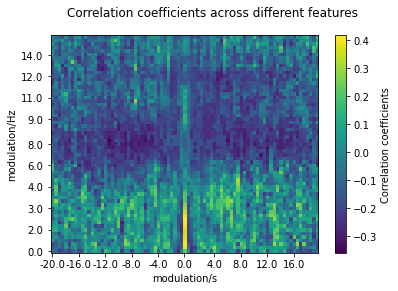

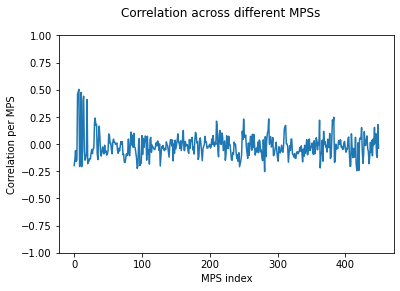

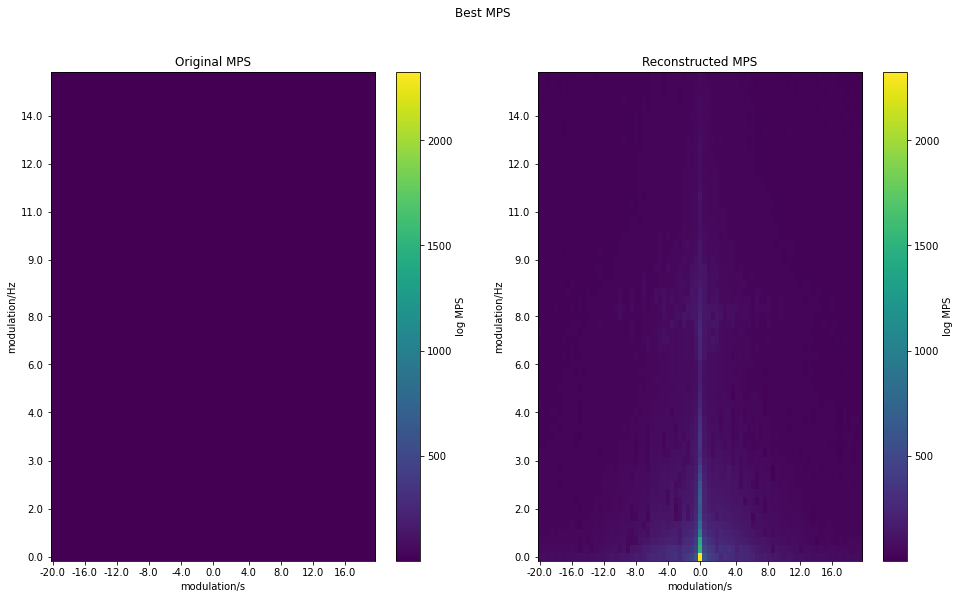

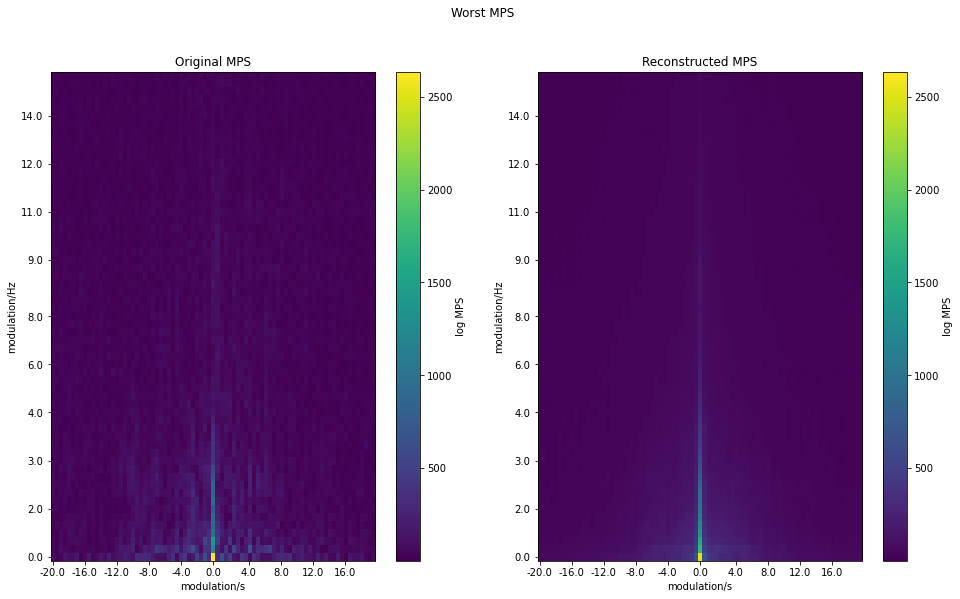

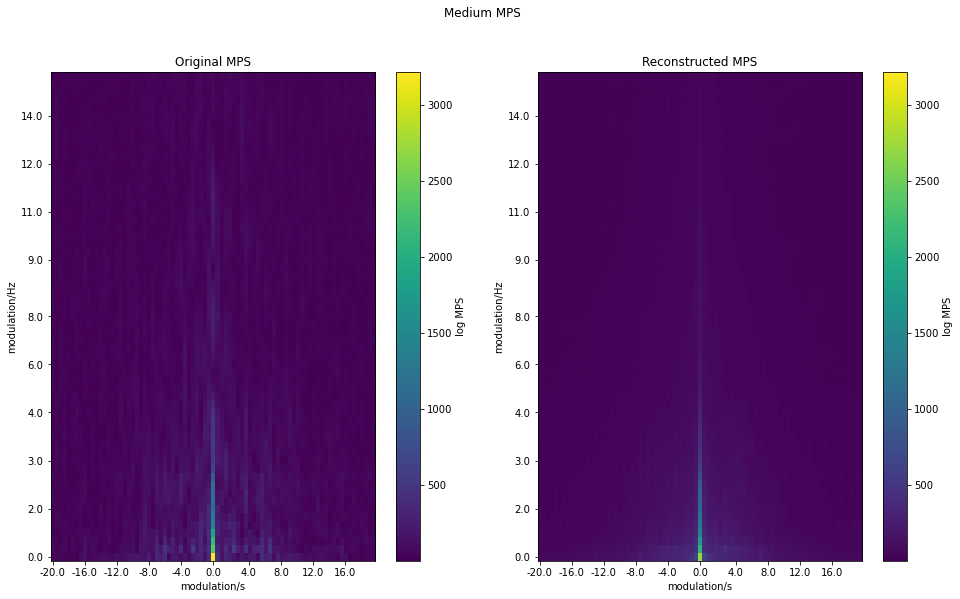

In [30]:
model_config = {'subjects':['01'], 'runs':[[1]]}
input_dir=os.path.join(path_to_project, 'decoding_model_bids/processed_data/')
stim_param_dir = os.path.join(path_to_project, 'decoding_model_bids/raw_data/processed_stimuli/')
output_dir=os.path.join(path_to_project,'decoding_model_bids/decoding_data/test_STM/')

# building a model
lag_par = 3
spatial_decoder = PCA(n_components=30)
# as you can see from help(dec.temporal_decoder) we need to pass class object and configuration separately 
# when initializing temporal_decoder object
ridge_config = {'alphas':(0,5,5), 'normalize': True}
temporal_decoder = dec.temporal_decoder(dec.myRidge, ridge_config, lag_par)
decoder = Pipeline([('spatial_decoder', spatial_decoder), ('temporal_decoder', temporal_decoder)])
dec.run_decoding(input_dir, output_dir, stim_param_dir, model_config, decoder)

Voala, we made it! We have construcetd the model which uses the temporal information contained in BOLD fMRI data.
Whether it really improves the reconstruction quality is a different question. In order to answer it we must run *analysis_desired.py* file to test different spatial and temporal models using different decoders and compare their performance. 
*Note, that some of these models, espacially, the onces exploinitn CCA (Canonical correlation analysis) are very computationally heavy and are not recommended to run on PCs.!* So think twice before executing the next line.

In [ ]:
%%bash 
path_to_project='/data/akitaitsev/'
cd $path_to_project"/decoding_model_bids/code/decoding/"
python analysis_desired.py

- ### mps2spectr

When all of your models elapsed, it is time to convert the predicted MPS representation into the spectrogram to see more representative result of our toil.
The functions to convert reconstructed are stored in the */code/mps2spectr/mps2spectrogram_convertor.py*.
When the file is called from the bash, it requires paths to original and reconstructed MPS and the output dir to save pictures at.
Let us compare the reconstructed spectrograms produced by our SM and STM.

In [21]:
%%bash 
path_to_project='/data/akitaitsev/'
cd $path_to_project"/decoding_model_bids/code/mps2spectr/"
python mps2spectrogram_convertor.py -h

usage: mps2spectrogram_convertor.py [-h] [-orig ORIG_FEATURE_DIR]
                                    [-reconstr RECONSTR_FEATURE_PATH]
                                    [-output OUTPUT_DIR]

Convert original and reconstructed feature representation into spectrogram and
plot it.

optional arguments:
  -h, --help            show this help message and exit
  -orig ORIG_FEATURE_DIR, --orig_feature_dir ORIG_FEATURE_DIR
                        Directory with original feature representation.
  -reconstr RECONSTR_FEATURE_PATH, --reconstr_feature_path RECONSTR_FEATURE_PATH
                        PAth to file of reconstructed feature representation
  -output OUTPUT_DIR, --output_dir OUTPUT_DIR
                        Directory where to save spectrogram pictures


In [40]:
%%bash 
path_to_project='/data/akitaitsev/'
cd $path_to_project"/decoding_model_bids/code/mps2spectr/"
python mps2spectrogram_convertor.py -orig $path_to_project"/decoding_model_bids/raw_data/processed_stimuli/" -reconstr $path_to_project"/decoding_model_bids/decoding_data/test_ridge/sub-01/reconstructed_mps_sub-01.pkl" -output $path_to_project"/decoding_model_bids/decoding_data/test_ridge/sub-01/"
python mps2spectrogram_convertor.py -orig $path_to_project"/decoding_model_bids/raw_data/processed_stimuli/" -reconstr $path_to_project"/decoding_model_bids/decoding_data/test_STM/sub-01/reconstructed_mps_sub-01.pkl" -output $path_to_project"/decoding_model_bids/decoding_data/test_STM/sub-01/"

Figure(1600x900)
Figure(1600x900)
Figure(1600x900)
Figure(1600x900)
Figure(1600x900)
Figure(1600x900)


Now let us see the images:

SM


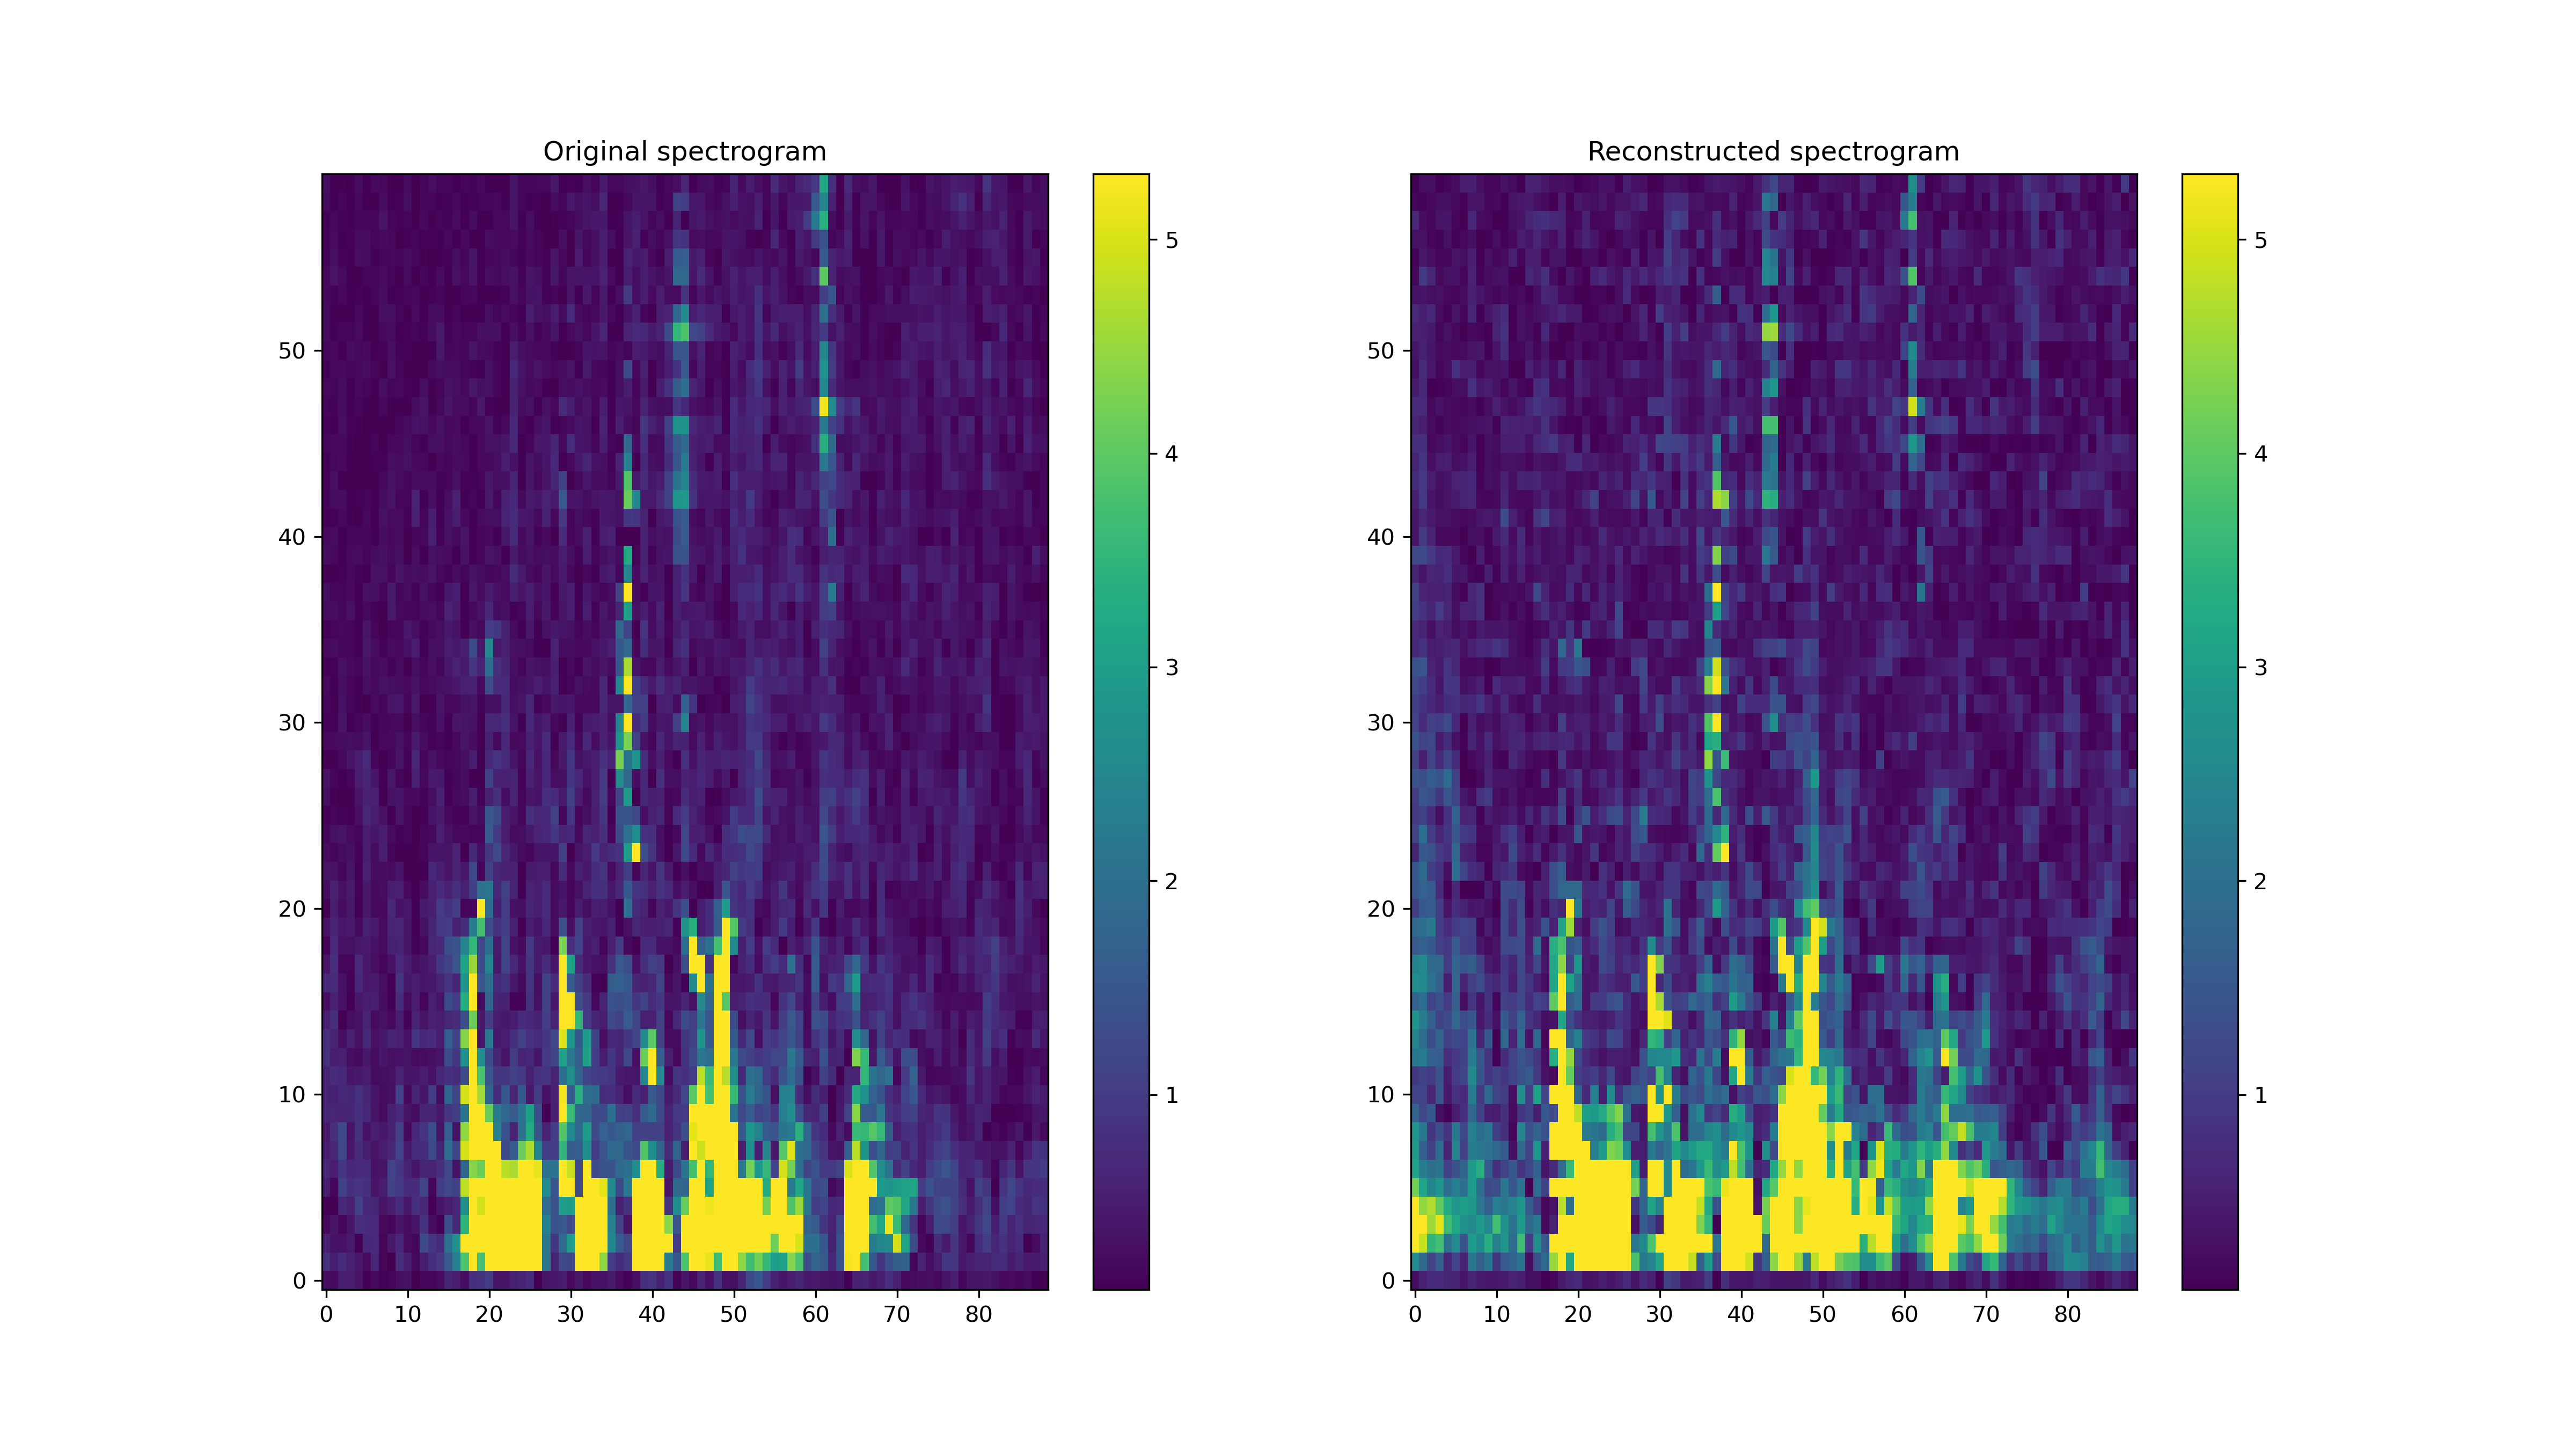

In [42]:
from IPython.display import Image
print('SM')
Image(os.path.join(path_to_project,'decoding_model_bids/decoding_data/test_ridge/sub-01/reconstr_and_orig_spectr_MID.png'), width = 600, height = 300)

STM


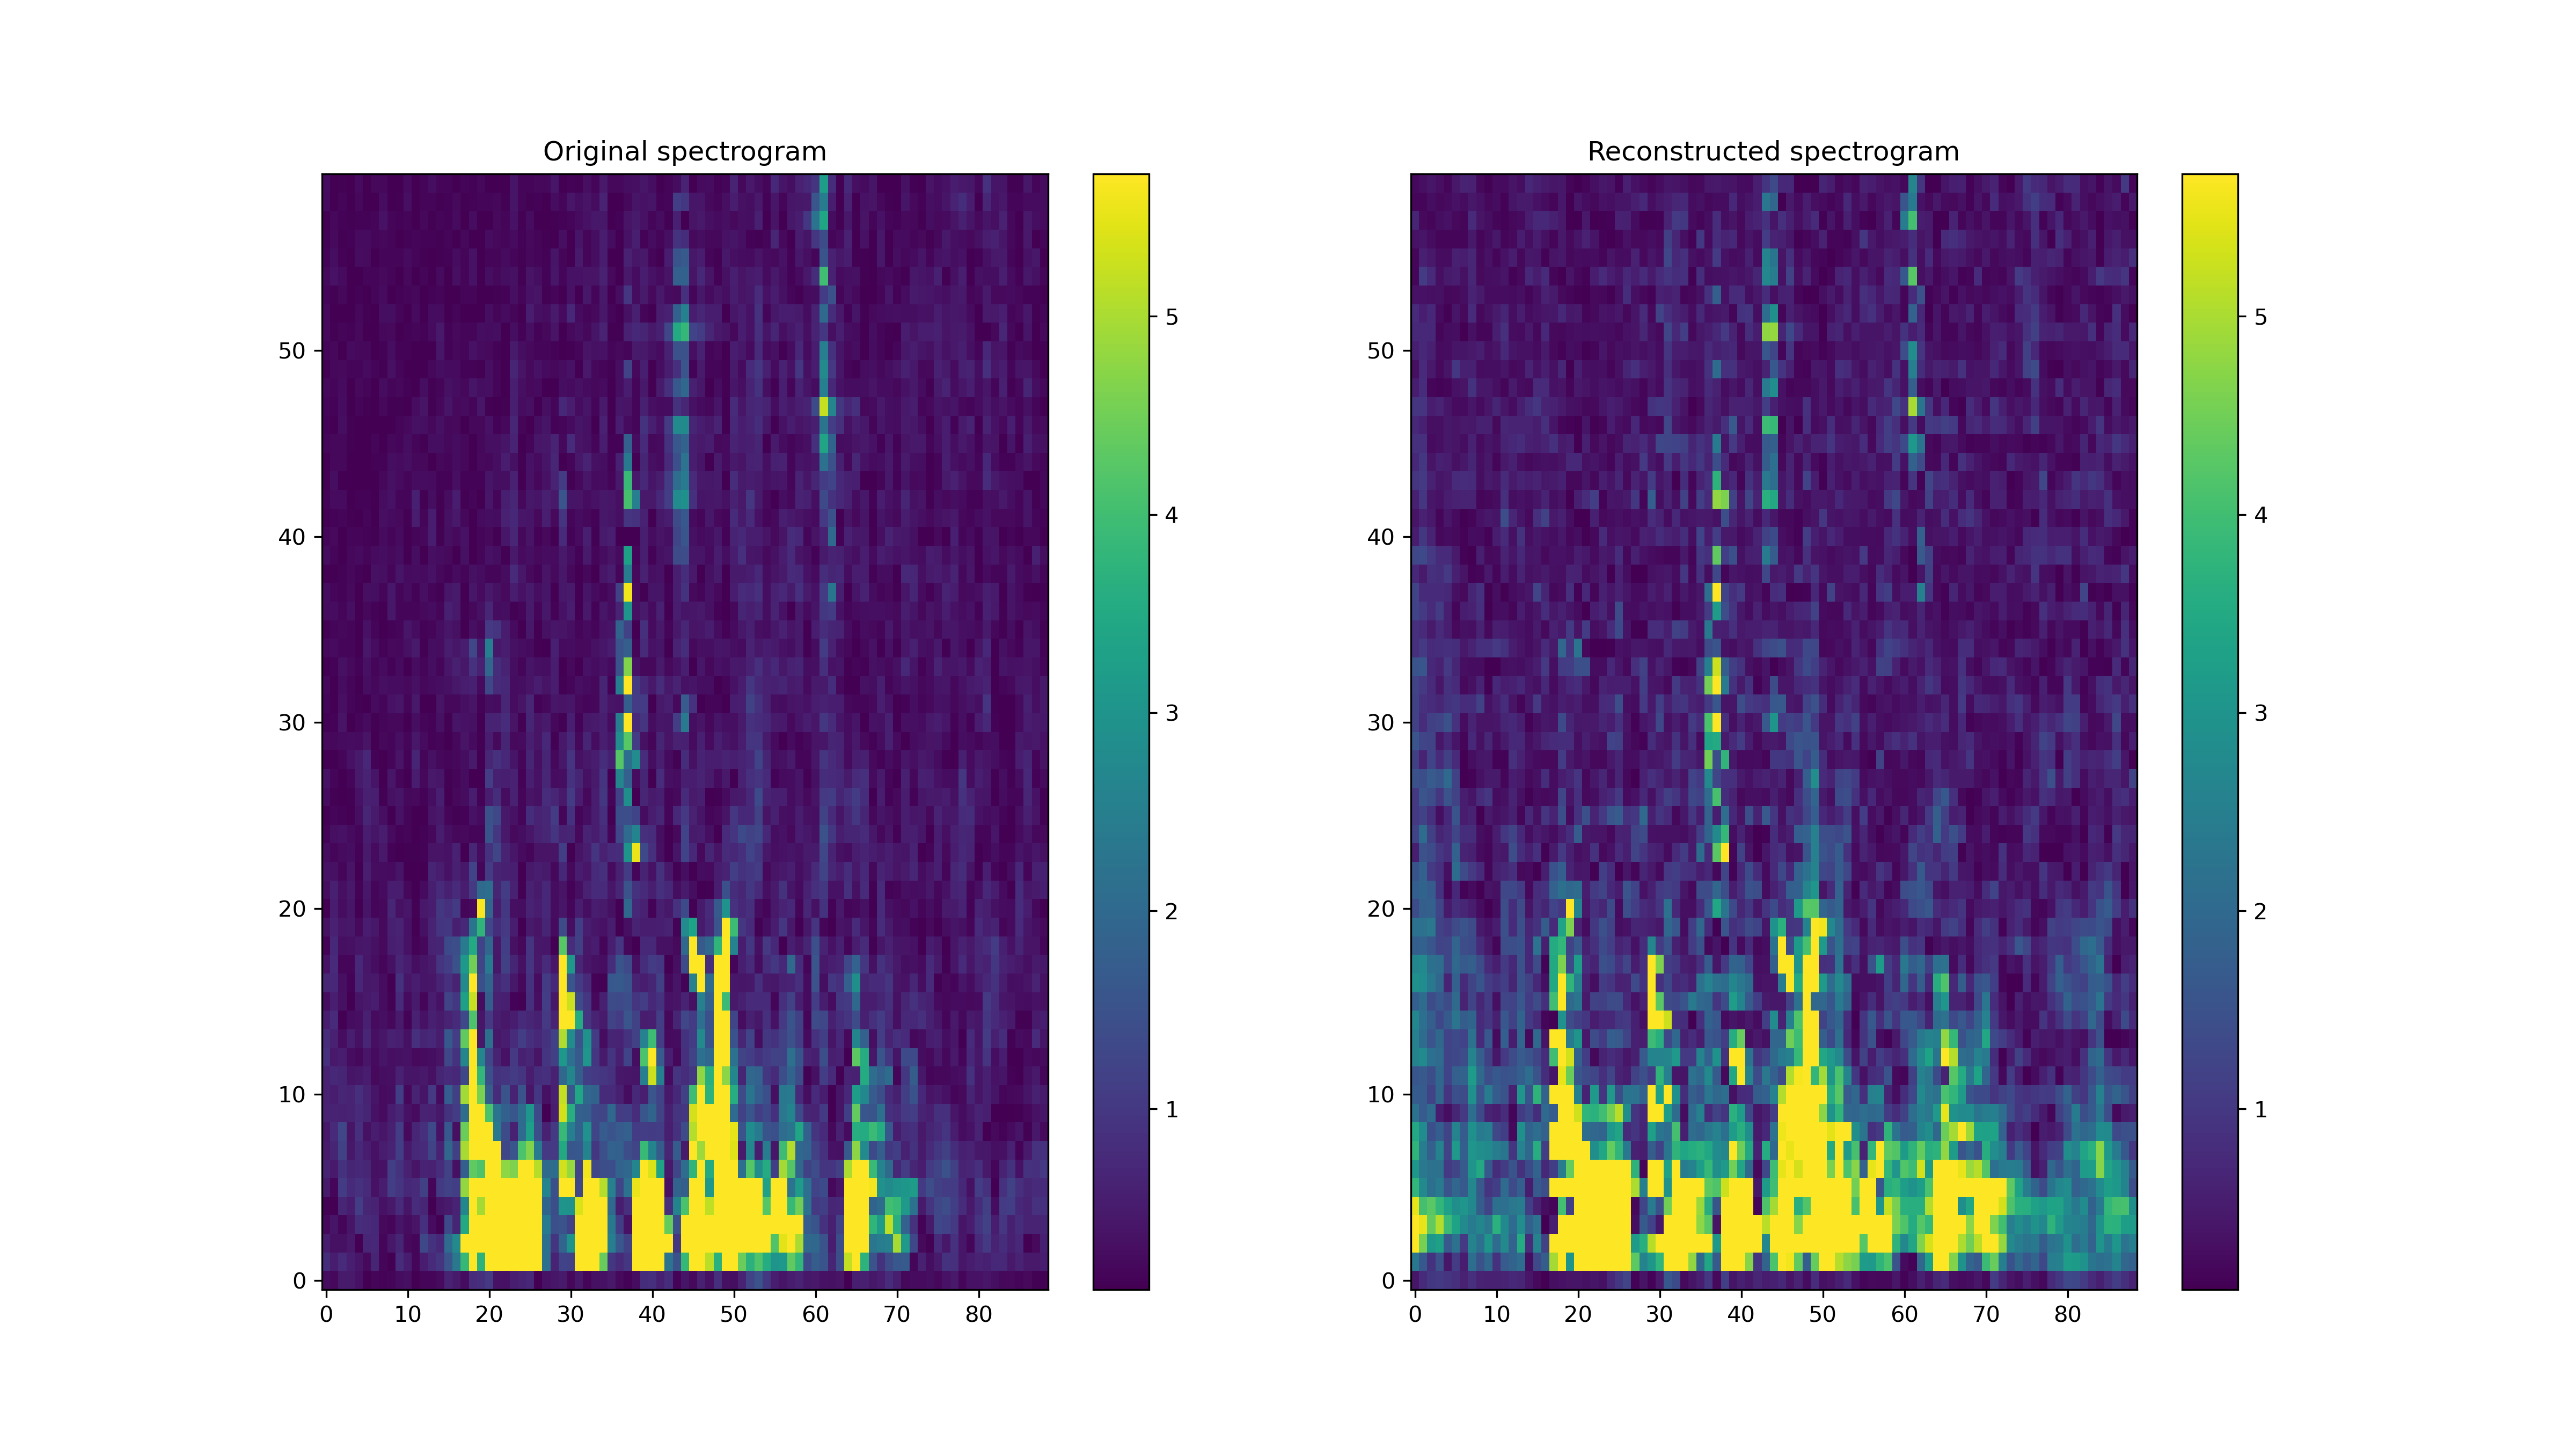

In [43]:
print('STM')
Image(os.path.join(path_to_project,'decoding_model_bids/decoding_data/test_STM/sub-01/reconstr_and_orig_spectr_MID.png'), width = 600, height = 300)

- The file *convert_mps_to_spectrogram.py* actually does the convertation on the models I was interrested in in this project.

Once you are finished running your models, it's time to visualize the results and do a statistical analysis.
For this we go to the directory */decoding_model_bids/code/stat_analysis/*.

*statistic_and_visualization_mps.py* and *statistic_and_visualization_spectr.py*:
1. show violin plots of the distribution of correlation values across spatial and spatial-temporal models for the reconstructed MPS and spectrograms for 3 subjects. 
2. pack data into long format pandas data frame
3. output 3 way mixed ANOVA summary tables (with subject as within observations)
4. output 3 way ANOVA tables for correspoining correlation values and save the anova table (ANOVA facotrs: *model_type*, *model*,*subject*).
All the data is saved into /decoding_model_bids/decoding_data/statistics/

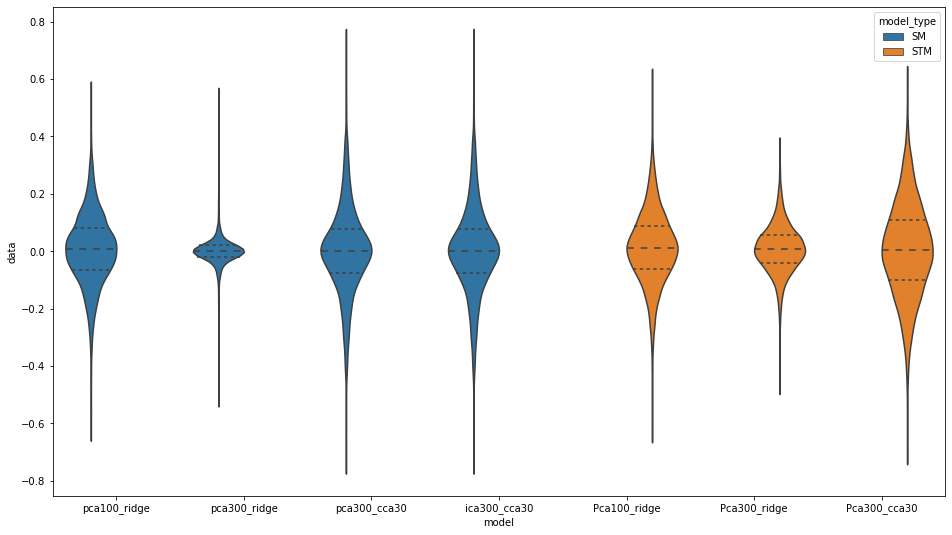

/home/akitaitsev/anaconda3/lib/python3.8/site-packages/pingouin/distribution.py:950: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d)**d



ANOVA SUMMARY

Source           SS    DF1    DF2      MS       F    p-unc    p-GG-corr     np2      eps    sphericity    W-spher    p-spher
-----------  ------  -----  -----  ------  ------  -------  -----------  ------  -------  ------------  ---------  ---------
model_type    0.000      1      1   0.000  -2.435    1.000      nan       1.697  nan           nan            nan    nan
model         0.000      6      6   0.000   0.884    0.558        0.116   0.469    0.306         0.000        inf      0.000
Interaction  -0.000      6      6  -0.000  -0.571    1.000      nan      -1.331  nan           nan            nan    nan

                    sum_sq       df          F    PR(>F)
C(model)          0.144501      6.0   1.454320  0.227840
C(model_type)     0.024083      1.0   1.454320  0.227840
C(subject)        0.344251      2.0  10.394101  0.000031
Residual       1248.635790  75401.0        NaN       NaN


/home/akitaitsev/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1830: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 6, but rank is 1
  warnings.warn('covariance of constraints does not have full '


In [12]:
path_to_project='/data/akitaitsev'
import os
file_mps = os.path.join(path_to_project, 'decoding_model_bids', 'code', 'stat_analysis', 'statistics_and_visualization_mps.py')
exec(open(file_mps).read())

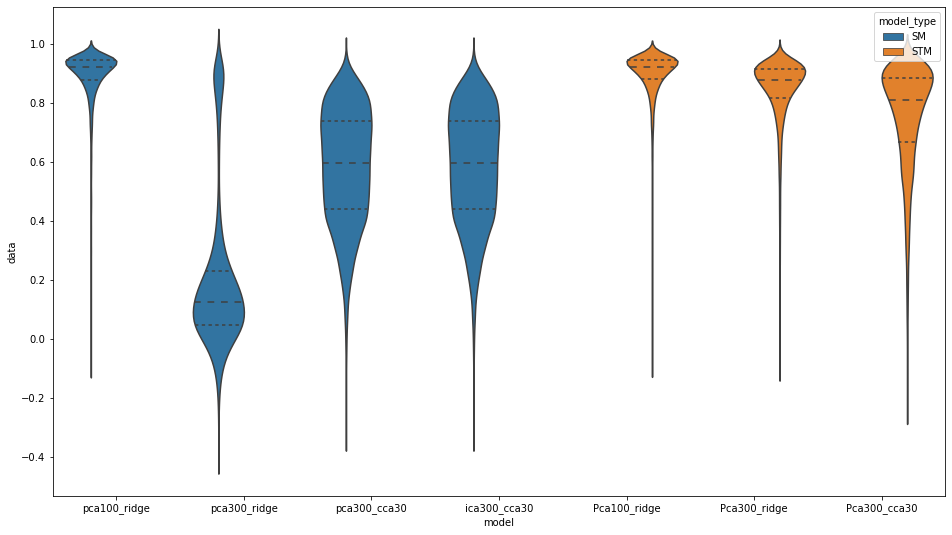

        Source        SS  DF1  DF2        MS         F     p-unc        np2  \
0   model_type  0.363601    1    1  0.363601 -1.012169  1.000000  83.175662   
1        model  1.113331    6    6  0.185555  2.959383  0.106239   0.747435   
2  Interaction -0.363601    6    6 -0.060600 -0.966501  1.000000 -28.851556   

        eps  
0       NaN  
1  0.190512  
2       NaN  

ANOVA SUMMARY

Source           SS    DF1    DF2      MS       F    p-unc      np2      eps
-----------  ------  -----  -----  ------  ------  -------  -------  -------
model_type    0.364      1      1   0.364  -1.012    1.000   83.176  nan
model         1.113      6      6   0.186   2.959    0.106    0.747    0.191
Interaction  -0.364      6      6  -0.061  -0.967    1.000  -28.852  nan

                    sum_sq       df           F        PR(>F)
C(model)          0.266687      6.0    1.463994  2.263004e-01
C(model_type)     0.044448      1.0    1.463994  2.263004e-01
C(subject)       12.741939      2.0  209.842677

/home/akitaitsev/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1830: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 6, but rank is 1
  warnings.warn('covariance of constraints does not have full '


In [13]:
path_to_project='/data/akitaitsev'
import os
file_spectr = os.path.join(path_to_project, 'decoding_model_bids', 'code', 'stat_analysis', 'statistics_and_visualization_spectr.py')
exec(open(file_spectr).read())

As we can see the results factors (apart from the subect) are not significant.
This is probably due to the large intersubject variation.
Whatever the reason is we can summarize the results fom performance of our models on both feature types on one final graph.
For this we run the  *violin_plot_mps_and_spectr.py* file.

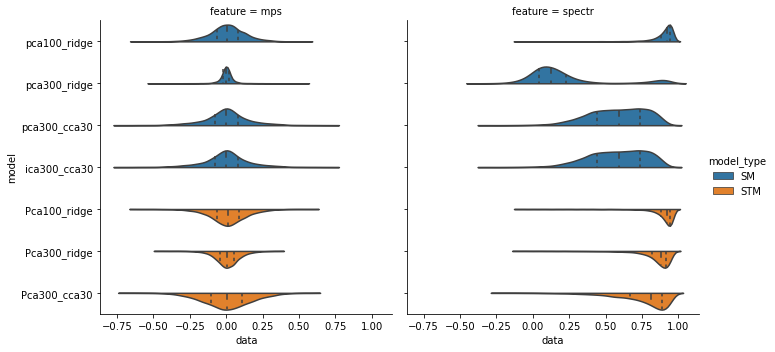

In [14]:
path_to_project='/data/akitaitsev'
import os
file_spectr = os.path.join(path_to_project, 'decoding_model_bids', 'code', 'stat_analysis', 'violin_plot_mps_and_spectr.py')
exec(open(file_spectr).read())

To sum up after going through all of this analysis we can see that:


1. *Correlation between original and reconstructed MPS is much lower that between original and reconstructed spectrogram*.
    *This might be due to*:
    - *abundace of "excessive" features in MPS which not important for stimulus reconstruction (high modulations/Hz and modulations/s)*
    - *addition of phase information extracted from the original feature representation in the process of convertring predicted MPS into spectrogram.*
2. *The benefit from incorporating temporal information into the model is scarce if any.*
3. *The simplest of all the tested models (pca100_ridge) yielded the best results in spectrogram reconstruction.*

We've made it! This is the end of this notebook!